In [1]:
import geopandas as gpd
import pandas as pd 
from sklearn import preprocessing 
from tqdm import tqdm
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import evaluation
import math
import random
import community
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from modutils import mod_calc
from copy import deepcopy
device = torch.device('cpu')

In [2]:
sample_num = 2000

In [3]:
# 确认节点数量
bs_gpd = gpd.read_file('../../data/basestation-gis/basestation_aggregation.shp')
bs_gpd = bs_gpd.iloc[:sample_num:, ::]
bs_num = bs_gpd.shape[0]

# 构造图节点
nodes_list = list(range(bs_num))
G = nx.Graph()
G.add_nodes_from(nodes_list)

# 读取邻接矩阵adjacent
# 以工作日(周一)的早高峰时段为例
adj = pd.read_csv('../../data/adj/adj_20151109_0002.csv')
adj = adj.iloc[:, 1:].values
adj = adj[:sample_num:, :sample_num:]
adj = adj + adj.T
for i in range(sample_num): adj[i, i] = 0
    
for i in tqdm(range(bs_num)):
    for j in range(bs_num):
        tmp = adj[i, j]
        if tmp>0: G.add_edge(i, j, weight=tmp)

100%|██████████| 2000/2000 [00:03<00:00, 578.89it/s]


In [82]:
class CDRAE(nn.Module):
    def __init__(self, A, num_feat, num_hidden):
        super(CDRAE, self).__init__()
        # self.num_feat = num_feat # 特征数 f
        # self.num_hidden = num_hidden # 隐含数 h
        self.A = A
        self.d = torch.tensor(list(dict(G.degree()).values()), dtype=np.float).contiguous().view(-1, 1)
        self.B = self.A - torch.div(torch.mm(self.d, self.d.T), torch.norm(self.A, p=1))
        self.B_norm = torch.div(self.B, torch.norm(self.A, p=1))
        self.W_0 = nn.Parameter(torch.ones(num_feat, num_hidden)) # [1][f*h]

    def forward(self, A):
        global featureSelector # 
        global weight_feature # 
        relu = nn.ReLU()
        featureSelector = relu(self.W_0) # [1][f*h]
        weight_feature = featureSelector

        # H = torch.mm(torch.mm(self.I,A_hat),self.I.T)
        H = torch.mm(torch.mm(weight_feature.T, self.B_norm.float()), weight_feature) # weight_feature 就是我们要求的U
        H = torch.div(H, H.sum(axis=0)) # 按照每一列进行归一化，列为axis=0的方向。
        m = nn.Softmax(dim=0)
        return m(H)
    
def lossFn(output): 
    return torch.trace(-torch.log(output))

In [85]:
clusters_number = 15
A_hat = torch.tensor(nx.adjacency_matrix(G).todense(), dtype=np.float) # a matrix: A
X = np.identity(G.number_of_nodes(), dtype=np.float)

num_feat = len(G.nodes()) # f = 节点数
num_hidden = clusters_number # h = 聚类数

model = CDRAE(A_hat, num_feat, num_hidden).to(device)

optimizer = optim.Adam(model.parameters(),lr=5e-3,weight_decay=0,betas=(0.5, 0.999), eps=1e-08)

wf_list = []

A_hat_tensor = torch.Tensor(A_hat.float()).to(device)
X_tensor = torch.Tensor(X).to(device)

loss_hist = []
modularity_hist = []
# acc_hist = []

for epoch in range(1000):
    model.train()
    model.zero_grad()
    output = model(A_hat_tensor)
    ############################################
    loss = lossFn(output)
    loss_hist.append(loss.item())
    ############################################
    gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
    labels_pred = gumbel_matrix.data.numpy()
    modularity = community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight')
    modularity_hist.append(modularity)
    
    wf_list.append(deepcopy(weight_feature.detach()))
    
    if epoch%10==0: 
        print('Epoch: ', epoch, '; Loss: ', round(loss.item(), 4), '; Modulariy: ', round(modularity, 4))
    loss.backward()
    optimizer.step()

Epoch:  0 ; Loss:  40.6208 ; Modulariy:  0.0
Epoch:  10 ; Loss:  40.6191 ; Modulariy:  0.3269
Epoch:  20 ; Loss:  40.6085 ; Modulariy:  0.2366
Epoch:  30 ; Loss:  40.5869 ; Modulariy:  0.2183
Epoch:  40 ; Loss:  40.5535 ; Modulariy:  0.2618
Epoch:  50 ; Loss:  40.5064 ; Modulariy:  0.2718
Epoch:  60 ; Loss:  40.4424 ; Modulariy:  0.3287
Epoch:  70 ; Loss:  40.3562 ; Modulariy:  0.3423
Epoch:  80 ; Loss:  40.2389 ; Modulariy:  0.3533
Epoch:  90 ; Loss:  40.0738 ; Modulariy:  0.3444
Epoch:  100 ; Loss:  39.8307 ; Modulariy:  0.3523
Epoch:  110 ; Loss:  39.6551 ; Modulariy:  0.3553
Epoch:  120 ; Loss:  39.586 ; Modulariy:  0.3651
Epoch:  130 ; Loss:  39.5145 ; Modulariy:  0.3802
Epoch:  140 ; Loss:  39.4378 ; Modulariy:  0.4032
Epoch:  150 ; Loss:  39.3512 ; Modulariy:  0.4124
Epoch:  160 ; Loss:  39.2514 ; Modulariy:  0.4234
Epoch:  170 ; Loss:  39.1335 ; Modulariy:  0.4285
Epoch:  180 ; Loss:  38.9923 ; Modulariy:  0.4309
Epoch:  190 ; Loss:  38.8227 ; Modulariy:  0.4389
Epoch:  200 ; L

### 加ReLU，效果如下

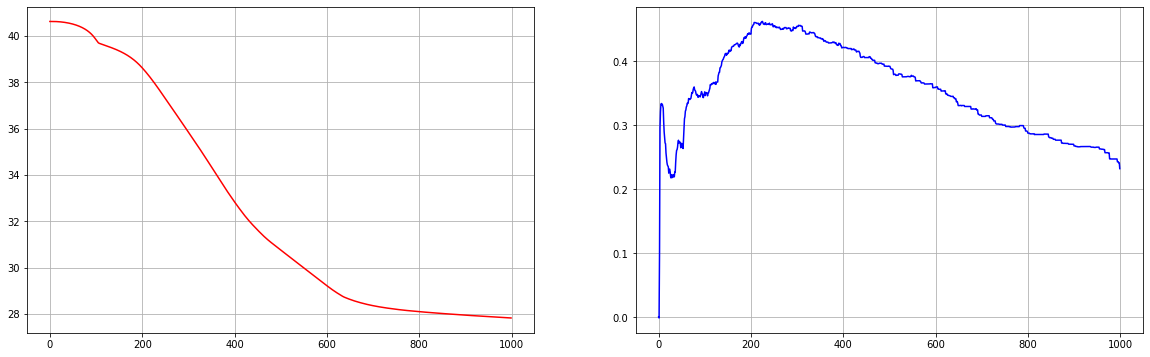

torch.Size([2000, 15])


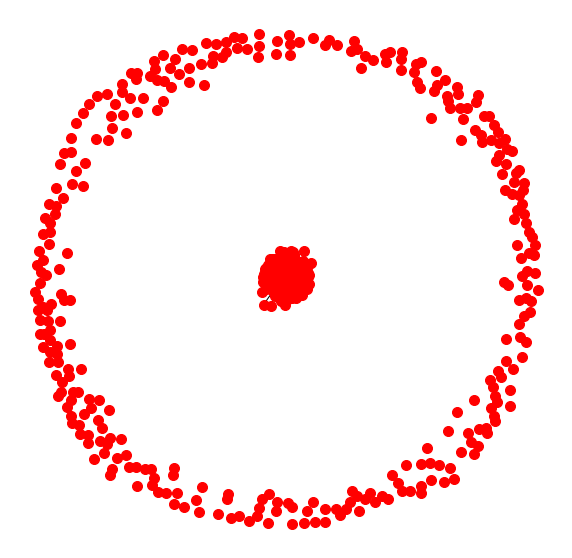

Modularity_false is 0.62846
Modularity_true is 0.23217


In [86]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print('Modularity_false is %.5f' %evaluation.modularity(G, labels_pred))
print('Modularity_true is %.5f' %community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight'))

### 不加ReLU，效果如下

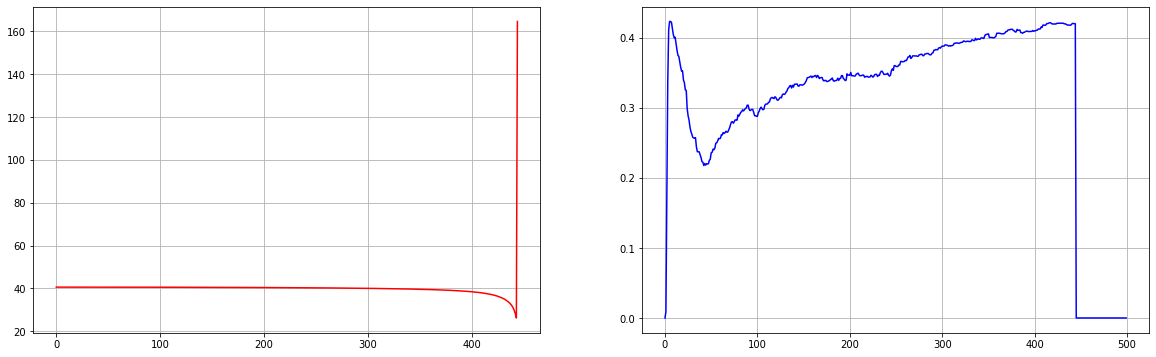

torch.Size([2000, 15])


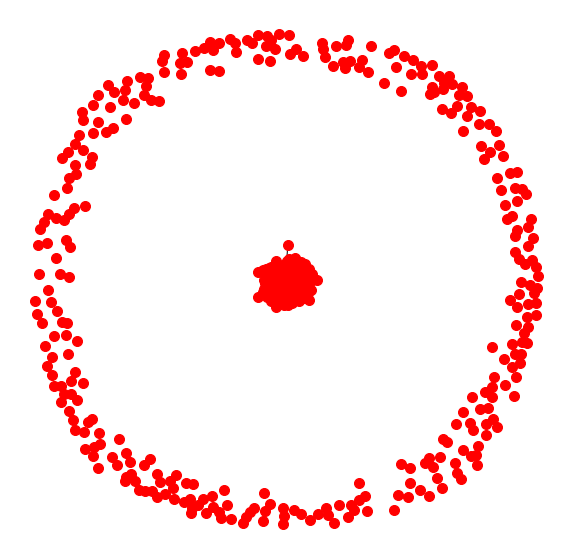

Modularity_false is 0.98110
Modularity_true is 0.00000


In [30]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print('Modularity_false is %.5f' %evaluation.modularity(G, labels_pred))
print('Modularity_true is %.5f' %community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight'))
# color = []
# for c in range(len(gumbel_matrix)):
#     if(gumbel_matrix[c] == 0):
#         color.append('r')
#     elif(gumbel_matrix[c] == 1):
#         color.append('g')
#     elif(gumbel_matrix[c] == 2):
#         color.append('teal')
#     elif(gumbel_matrix[c] == 3):
#         color.append('greenyellow')
#     elif(gumbel_matrix[c] == 4):
#         color.append('pink')
#     elif(gumbel_matrix[c] == 5):
#         color.append('dimgrey')
#     elif(gumbel_matrix[c] == 6):
#         color.append('peachpuff')
#     elif(gumbel_matrix[c] == 7):
#         color.append('gold')
#     elif(gumbel_matrix[c] == 8):
#         color.append('m')
#     elif(gumbel_matrix[c] == 9):
#         color.append('aqua')
#     elif(gumbel_matrix[c] == 10):
#         color.append('indianred')
#     elif(gumbel_matrix[c] == 11):
#         color.append('sienna')
# plt.figure(figsize=(12, 12))
# options = {
#     'node_color': color,
#     'node_size': 50,
#     'line_color': 'grey',
#     'linewidths': 0,
#     'width': 0.1,
# }
# plt.figure(figsize=(10, 10))
# plt.axis('off')
# nx.draw_networkx(G, pos=pos, node_size=150, node_color=color, with_labels=False)
# plt.show()